In [1]:
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
!pip install diffusers datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [4]:
# !pip install diffusers
from diffusers import DDPMPipeline

model_id = "google/ddpm-bedroom-256"

pipeline = DDPMPipeline.from_pretrained(model_id) # you can replace DDDPMPipeline with DDIMPipeline or PNDMPipeline
pipeline.to(device)
image = pipeline().images[0]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

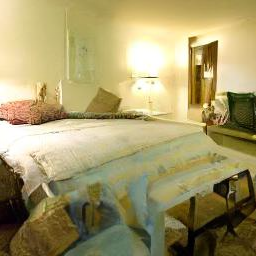

In [5]:
image

In [6]:
image.save("clear_image.png")

In [7]:
import cv2
from torchvision import transforms
import torch
import numpy as np
from tqdm import tqdm_notebook as tqdm
image = cv2.imread("/content/clear_image.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread("/content/mask.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

In [8]:
image = (image / 255.0)*2 - 1
image = torch.tensor(image, dtype=torch.float32).permute(2,0,1) # colour, height, width
image = image.unsqueeze(0) # batch, colour, height, width
image = image.to(device)

mask = (mask / 255.0)
mask = torch.tensor(mask, dtype=torch.float32).permute(2,0,1) # colour, height, width
mask = mask.unsqueeze(0) # batch, colour, height, width
mask = mask.to(device)

In [9]:
image.shape

torch.Size([1, 3, 256, 256])

In [10]:
mask.shape

torch.Size([1, 3, 256, 256])

In [11]:
X0_with_mask = image * mask

In [17]:
harmonize_steps = 10
semantic_steps = 10
scheduler = pipeline.scheduler
noise = torch.randn(X0_with_mask.shape).to(X0_with_mask.device)

for i in tqdm(range(len(scheduler.timesteps))):
  t = scheduler.timesteps[i]
  if i == 0:
    Xt = noise

  noise = torch.randn(X0_with_mask.shape).to(X0_with_mask.device)
  X_t_minus_1_with_mask = scheduler.add_noise(X0_with_mask, noise, t-1)

  # after each 10 timesteps
  if i % semantic_steps == 0:

    for h in range(harmonize_steps):
      with torch.no_grad():
        Xt_model_input = scheduler.scale_model_input(Xt, t)
        noise_pred = pipeline.unet(Xt_model_input, t)["sample"]
        pred_X_t_minus_1 = scheduler.step(noise_pred, t, Xt).prev_sample
        X_t_minus_1 = pred_X_t_minus_1 * (1-mask) + X_t_minus_1_with_mask * mask
        noise = torch.randn(X0_with_mask.shape).to(X0_with_mask.device)
        if h < harmonize_steps - 1:
          Xt = X_t_minus_1*np.sqrt(1-scheduler.betas[t-1]) + np.sqrt(scheduler.betas[t-1]) * noise
        else:
          Xt = X_t_minus_1
  else:
    Xt_model_input = scheduler.scale_model_input(Xt, t)
    with torch.no_grad():
      noise_pred = pipeline.unet(Xt_model_input, t)["sample"]
    X_t_minus_1 = scheduler.step(noise_pred, t, Xt).prev_sample
    Xt = X_t_minus_1








<ipython-input-17-9897eebf2014>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(scheduler.timesteps))):


  0%|          | 0/1000 [00:00<?, ?it/s]

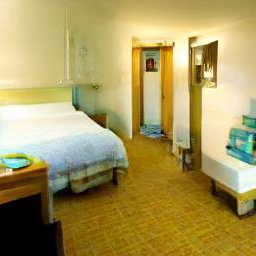

In [14]:
from PIL import Image
Image.fromarray(np.uint8(((Xt[0].permute(1,2,0).cpu().clip(-1, 1) * 0.5 + 0.5)*255).long()))

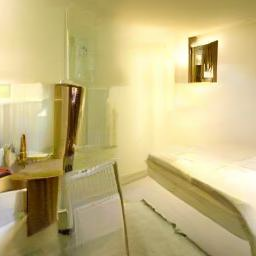

In [16]:
from PIL import Image
Image.fromarray(np.uint8(((Xt[0].permute(1,2,0).cpu().clip(-1, 1) * 0.5 + 0.5)*255).long()))

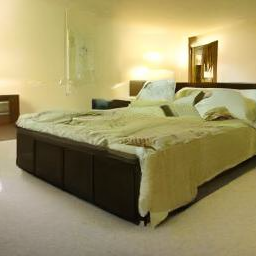

In [18]:
from PIL import Image
Image.fromarray(np.uint8(((Xt[0].permute(1,2,0).cpu().clip(-1, 1) * 0.5 + 0.5)*255).long()))